Copyright (c) 2025 Mitsuru Ohno  
Use of this source code is governed by a BSD-3-style  
license that can be found in the LICENSE file.  

## 当ノートブックのワークフロー  
1. 未知の速度定数を含む、csvに書き込んだ反応式を読み込む。  
2. 化学種の濃度の経時変化の実験データを読み込む。実験データには欠損を含んでもよい。  
2. 化学種ごとの微分型の反応速度式を作成する。速度定数が未知の素反応にはシンボリックな変数が割り振られる、  
3. 作成した微分方程式を、数値解析可能な形式にする  
4.  scipy.optimize.minimizeを使い、化学種ごとの濃度の経時変化が、実験値と近づくように、未知の速度定数を求める。  
5. 経時変化を図示する  


## 使用方法の要約
基本的な使用: RxnIVPsolv("sample_data.csv")でインスタンス化  
数値積分: get_ode_system()で必要なオブジェクトを取得  
エラーハンドリング: try-except文でエラーをキャッチ  
可視化: matplotlibで結果をプロット  
パラメータ解析: 異なる初期条件での比較  
これらの使用例は、現在のコードが正しく動作することを前提としています。もしエラーが発生した場合は、debug_ode_system()メソッドで詳細な情報を確認できます。  

## 反応式を記載したcsvファイルを指定する  

In [1]:
file_path_rxn = '../sample_data/sample_rxn_3b.csv'  # CSVファイルのパスを指定

In [2]:
# development phase
# Add the parent directory (one level up from the notebook's location) to the Python path
import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..'))

## 反応速度式をscipy.integrate.solve_ivpで処理できる連立微分方程式にする  

In [3]:
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sympy import Symbol
from sympy.core.symbol import Symbol as SympySymbol
import inspect

from src.rxnfit.build_ode import RxnODEbuild, create_system_rhs
from src.rxnfit.solv_ode import SolverConfig, RxnODEsolver
from src.rxnfit.expdata_fit_sci import expdata_read, get_y0_from_expdata, ExpDataFitSci

# 反応速度式の作成

In [4]:
builded_rxnode = RxnODEbuild(file_path_rxn)

In [5]:
builded_rxnode.get_ode_info(debug_info=True)

number of species: 5
unique species: ['ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
rate constant: {'k1': 0.0115, 'k2': k2, 'k3': 0.201}

=== debug info ===
Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
order of args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
system of ODE: {'ClCH2COOH': '-k1*ClCH2COOH(t)*H2O(t)+k2*ClCH2COOOH(t)', 'H2O': '-k1*ClCH2COOH(t)*H2O(t)+k1*ClCH2COOH(t)*H2O(t)+k3*H2O2(t)', 'ClCH2COOOH': 'k1*ClCH2COOH(t)*H2O(t)-k2*ClCH2COOOH(t)', 'O2': '0.5*k2*ClCH2COOOH(t)+0.5*k3*H2O2(t)', '

In [6]:
# 作成した微分方程式
builded_rxnode.get_ode_system()[0]

Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']


[Eq(Derivative(ClCH2COOH(t), t), k2*ClCH2COOOH(t) - 0.0115*ClCH2COOH(t)*H2O(t)),
 Eq(Derivative(H2O(t), t), 0.201*H2O2(t)),
 Eq(Derivative(ClCH2COOOH(t), t), -k2*ClCH2COOOH(t) + 0.0115*ClCH2COOH(t)*H2O(t)),
 Eq(Derivative(O2(t), t), 0.5*k2*ClCH2COOOH(t) + 0.1005*H2O2(t)),
 Eq(Derivative(H2O2(t), t), -0.201*H2O2(t))]

In [7]:
# 速度定数の確認
print(builded_rxnode.rate_consts_dict)

check_type = [v for v in builded_rxnode.rate_consts_dict.values()]
[type(e) for e in check_type]

{'k1': 0.0115, 'k2': k2, 'k3': 0.201}


[float, sympy.core.symbol.Symbol, float]

## 経時変化の実験データを読み込み　　
### データフレーム化  

In [8]:
file_path_data = '../sample_data/sample_timecourse_3b.csv' # データファイルのパス
df1 = pd.read_csv(file_path_data)

expdata_read([df1,])  # 複数データフレームのリストを渡すとまとめて読み込み可能

[([array([ 0,  1,  4,  9, 13, 18, 22, 25, 28, 31]),
   array([ 0,  1,  9, 13, 18, 25, 31]),
   array([ 0,  1,  4,  9, 18, 22, 25, 28, 31]),
   array([ 0,  1,  4,  9, 13, 18, 22, 28, 31]),
   array([ 0,  1,  4,  9, 18, 25, 28, 31])],
  [array([2.945, 2.852, 2.477, 2.07 , 1.762, 1.356, 1.106, 0.88 , 0.707,
          0.557]),
   array([6.807, 6.614, 6.515, 6.569, 6.638, 6.697, 6.743]),
   array([0.   , 0.193, 0.385, 0.292, 0.169, 0.11 , 0.086, 0.065, 0.063]),
   array([13.99 , 14.083, 14.458, 14.867, 15.187, 15.557, 15.875, 16.205,
          16.374]),
   array([0.    , 0.    , 0.0415, 0.2925, 0.699 , 0.9705, 1.0645, 1.155 ])])]

### フィッティング  
ExpDataFitSci でシンボリックな速度定数をフィッティング。  


In [9]:
# ExpDataFitSci でフィッティング（t_range, df_list 必須）
t_range = (float(df1.iloc[:, 0].min()), float(df1.iloc[:, 0].max()))
fit_sci = ExpDataFitSci(builded_rxnode, [df1], t_range)
result, param_info = fit_sci.run_fit(p0=[0.04]) # 未知の速度定数の初期値

Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
最適化成功: True
最適化された速度定数:
  k2 = 0.0860359
残差二乗和: 348.182


In [10]:
# フィッティング結果で builded_rxnode を更新し、SolverConfig を取得
# fit_sci.get_fitted_rate_const_dict() と get_solver_config_args() を使用
builded_rxnode.rate_consts_dict.update(fit_sci.get_fitted_rate_const_dict())
config = SolverConfig(**fit_sci.get_solver_config_args())

## 数値積分を実行する  

In [11]:
# 最適化結果および与えたデータから、solve_ivp に渡す引数を作成
# 1. ODE システムと system_rhs を取得（builded_rxnode.rate_consts_dict は上記で更新済み）
ode_construct = builded_rxnode.get_ode_system()
(system_of_equations, sympy_symbol_dict, ode_system,
 function_names, rate_consts_dict) = ode_construct
system_rhs = create_system_rhs(ode_system, function_names)

# 2. 実験データの時間点を t_eval に使用（任意・省略可）
t_eval = np.array(df1.iloc[:, 0].values, dtype=float)

# 3. solve_ivp に渡す引数を構築（config を引き継ぎ、fun と t_eval を追加）
solve_ivp_kwargs = {
    'fun': system_rhs,
    **vars(config),
    't_eval': t_eval,
}

Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']


In [12]:
# 基本的な数値積分 -インスタンス化-
solved_rxnode = RxnODEsolver(builded_rxnode, config)

In [13]:
ode_construct, sol = solved_rxnode.solve_system()

Successfully created function for ClCH2COOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for ClCH2COOOH with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']
Successfully created function for H2O2 with args: ['t', 'ClCH2COOH', 'H2O', 'ClCH2COOOH', 'O2', 'H2O2']



=== Time-course plot ===


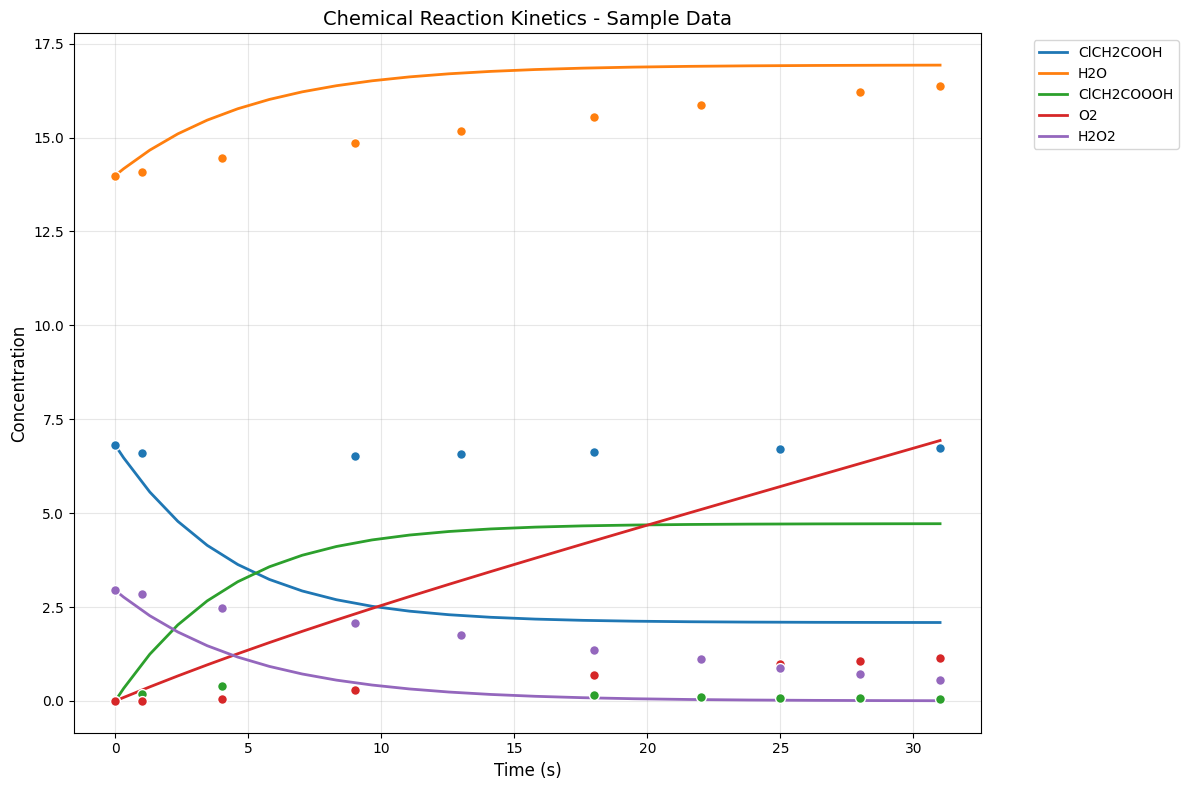


=== Concentration at the final time point ===
ClCH2COOH: 2.088259
H2O: 16.929206
ClCH2COOOH: 4.718741
O2: 6.933604
H2O2: 0.005794


In [14]:
# シミュレーション曲線に実験データ点を重ねる（線と点で色を揃える）
solved_rxnode.solution_plot(expdata_df=df1)